9.3　為替レート決定理論×ランダム・フォレスト回帰

　前節では、学習データとテストデータを用いることで、アセット・アプローチ理論に基づく実証モデルの「評価」を行いました。そして、最終セルの1％の利上げ時のドル円レートの予測では、線形モデルにより予測を実施しています。本例では、この為替レートの予測をランダム・フォレスト回帰により行い、線形モデル予測との比較を行います。まず汎用ライブラリとして、pandas、numpy、datetime、matplotlibを読み込みます。

In [1]:
#[1]汎用ライブラリの読み込み
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

　機械学習用のライブラリをインポートします。本例では、sklearnを用いて機械学習による実証モデルの性能評価を行い、ランダム・フォレスト回帰により予測値を算出します。インポートするライブラリには、最小二乗法を行うためのライブラリ、データを学習データとテストデータに分割するライブラリ、決定係数と平均二乗誤差から機械学習評価を行う2つのライブラリ、ランダム・フォレスト用ライブラリの計5つのライブラリをインポートします。

In [2]:
#[2]機械学習用ライブラリの読み込み
from sklearn.model_selection import train_test_split #学習・テストデータ分割のライブラリ
from sklearn.ensemble import RandomForestRegressor #ランダム・フォレスト推計用ライブラリ

　ドル円為替レート、日米消費者物価指数、日米10年債金利の1990年1月から2022年12月までのデータを取得します。本データの場合は、日時情報”Date”はデータとして利用しませんので、datetimeへ変換してインデックスとして利用します。

In [3]:
#[3]データの取得
url = "https://github.com/nagamamo/data/blob/main/9_2_fx_market_data.csv?raw=true"#Git-hubからCSVデータの入手
data = pd.read_csv(url)#データフレームの作成
data["Date"] = pd.to_datetime(data["Date"]) #日時をインデックスの変換のためdatetimeへ変換
US_Japan = data.set_index("Date")#日時をインデックスへ変換

　取得したデータから、ドル円レートの前月比（d_Yen）、日米インフレ率格差（d_P）、日米10年債金利スプレッド(d_R)を算出してpandasデータフレームにそれぞれの新変数列を追加します。この2つの説明変数が、購買力平価要因とマネタリー・アプローチ要因を表します。重ねて述べるように、sklearnではデータの入出力はnumpy配列を前提としていますので、pandasデータフレームのデータを「.value」により変換し、これをYとXとします。

In [4]:
#[4]採用変数の算出と定義
US_Japan['d_R']=US_Japan['10USB']-US_Japan['10JPB'] #日米長期金利差の算出
US_Japan['d_P']=US_Japan['P_US']-US_Japan['P_JP'] #日米インフレ率格差の算出
US_Japan['d_Yen']=US_Japan['Yen'].pct_change()*100 #為替レート前月比の算出
US_Japan=US_Japan.dropna()#欠損値の除去
Y=US_Japan['d_Yen'].values #被説明変数の定義と配列変更
X=US_Japan[['d_R','d_P']].values #説明変数の定義と配列変更

<ipython-input-4-fa42b6008f23>:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  US_Japan['d_Yen']=US_Japan['Yen'].pct_change()*100 #為替レート前月比の算出


　この可視化までの実装は、前節の例と同様です。

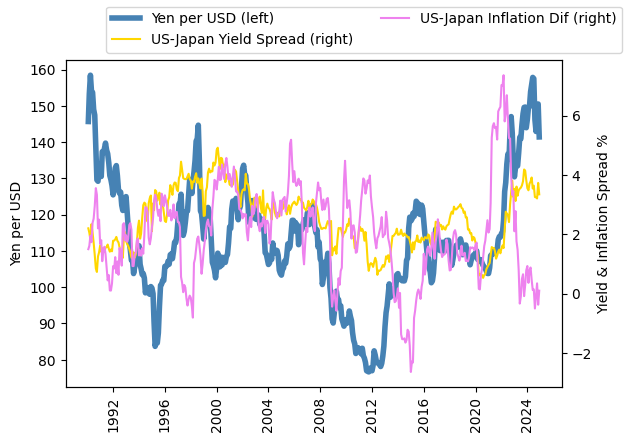

In [5]:
#[5]データの可視化
fig = plt.figure()
ax1 = fig.subplots()
ax2 = ax1.twinx()
ax1.plot(US_Japan['Yen'], lw=4, color="steelblue",label="Yen per USD (left)")
ax2.plot(US_Japan['d_R'], c="gold",label="US-Japan Yield Spread (right)")
ax2.plot(US_Japan['d_P'], c="violet",label="US-Japan Inflation Dif (right)")
fig.autofmt_xdate(rotation=90, ha="center")
plt.ylabel('Yen per USD')
ax1.set_ylabel('Yen per USD')
ax2.set_ylabel('Yield & Inflation Spread %')
fig.legend(ncol=2)
plt.show()

　次にデータを学習データ(X_train、Y_train)とテストデータ（X_test、Y_test）に分割し、学習データにアセット・アプローチ・モデル（ランダム・フォレスト）をフィッティングします。[6]１行目のコードは、学習データとテストデータを、ランダムに70％：30％に分割することを指示しています。決定係数と残差平方和から見たモデルの評価が高くない場合は、この比率を変更してください。

　2行目のコードで推計にランダム・フォレストを実行し、3行目において学習データを用いてフィッティングを行います。為替レート決定理論を機械学習により実装する際の重要な点は、

「**必ず事前に線形実証モデルによる検証を行い、係数値が理論と整合しているかを統計的に確認すること。**」

です。それを確認することなく機械学習を用いると、理論に整合しないモデルを用いて、予測値を算出することにつながります。

　4行目と5行目は、それぞれ学習データとテストデータを用いた為替レート（変化率）の予測値を算出します。この学習データとテストデータの予測値を比較することで、この実証モデルの性能を評価します。

In [6]:
#[6]アセット・アプローチ・モデルの推計と機械学習
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0)#学習データとテストデータの分割
model=RandomForestRegressor()#推計方法の定義
model.fit(X_train,Y_train)#フィッティング
Y_train_pred=model.predict(X_train)#学習データによる予測値の算出
Y_test_pred=model.predict(X_test)#テストデータによる予測値の算出

　米日インフレ率格差（d_P）、米日長期金利差（d_R）、ドル円レート（d_Yen）の実績値と学習データから算出される理論値をプロットします。本例ではランダムフォレスト回帰により予測値を算出しているため、前節の3次元プロット図とは異なったグラフになります。

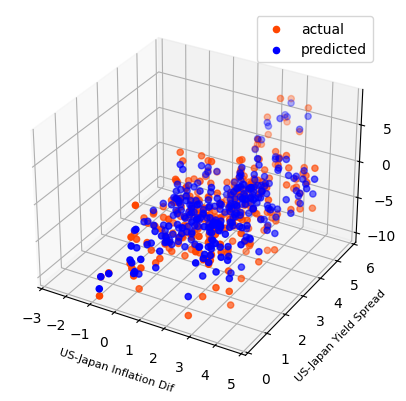

In [7]:
#[7]実績値と予測値のプロット
X_train1, X_train2 = np.split(X_train, 2, 1)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train1, X_train2, Y_train, marker="o",c='orangered',label='actual')
ax.scatter(X_train1, X_train2, Y_train_pred,marker="o", c='blue',label='predicted')
ax.set_xlabel('US-Japan Inflation Dif',size=8)
ax.set_ylabel('US-Japan Yield Spread',size=8)
ax.set_zlabel('Yen per USD',size=8)
plt.xlim(-3, 5)
plt.ylim(0, 6)
ax.legend()
plt.show()

　最後に、上記の結果を視覚的に確認するため、学習データとテストデータから算出された予測値と実績値との誤差をプロットします。

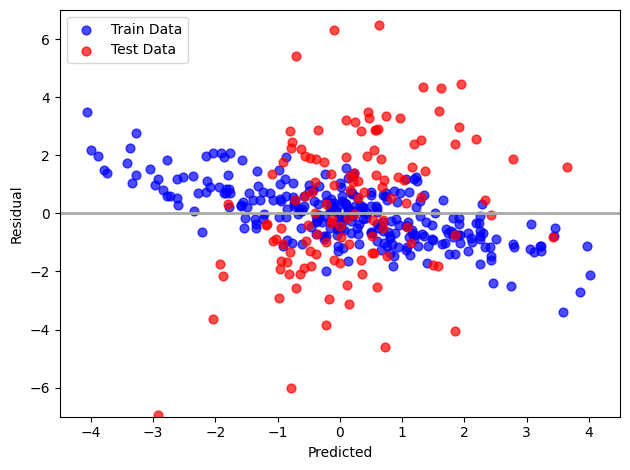

In [11]:
#[8]ランダム・フォレスト回帰結果の可視化
plt.scatter(Y_train_pred,Y_train_pred-Y_train,c='blue',marker='o',s=40,alpha=0.7,label='Train Data')
plt.scatter(Y_test_pred,Y_test_pred-Y_test,c='red',marker='o',s=40,alpha=0.7,label='Test Data')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-5,xmax=5,lw=2,color='darkgray')
plt.xlim([-4.5,4.5])
plt.ylim([-7,7])
plt.tight_layout()
plt.show()

　最後のセルは、将来のドル円レートを予測するコードです。このコードは、線形モデルもランダム・フォレスト回帰も同じです。それぞれlast（直近の米日金利差）、add_spread（未来の金利拡大もしくは縮小幅）、add_CPI（未来の米日インフレ率格差）を入力すれば、その「未来」時点でのドル円レートが計算されます。

　直近の値は、任意に与えても差し障りありません。

　米連邦準備制度理事会もしくは日本銀行の金融引き締めによる長期金利差の変化の為替レートへの影響のみを確認したい場合は、add_CPI=0とすると、政策効果のみを演算できます。金融政策を中立のまま維持し、インフレ率がいずれかの国で1％上昇した場合のドル円レートへの影響も試算できます。

In [ ]:
#[9]ドル円レートの予測
lastR=US_Japan.d_R[-1] #標本データ直近の米日金利差
lastP=US_Japan.d_P[-1] #標本データ直近の米日インフレ率格差
add_spread=1.0 #金利スプレッド拡大幅
add_CPI=0.0 #インフレ率格差拡大幅
spot=161.54 #直近ドル円レート
senario_R=lastR+add_spread
senario_P=lastP+add_CPI
a=model.predict([[senario_P,senario_R]])
spot*(1+a/100)